**types of simulators**
- qasm simulator which executes the quantum circuits with multiple shots to smulate a noisy backend quantum system
- statevector simulator which provides the state vector of the quantm circuit
- unitary simulator which provides the unitary matrix of the quantum circuit being executed
- pulse simulator which simulates pulse schedules to execute directly to the various channels on the hardware

In [47]:
from qiskit_aer import Aer

In [48]:
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator')]

In [49]:
from dotenv import load_dotenv
import os
load_dotenv()  # take environment variables from .env.
from qiskit_ibm_runtime import QiskitRuntimeService, fake_provider

provider = QiskitRuntimeService(channel="ibm_quantum", token=os.getenv('QISKIT_IBM_TOKEN'))

In [50]:
provider.backends(simulator=False)

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyiv')>,
 <IBMBackend('ibm_sherbrooke')>]

In [51]:
provider.backends(simulator=True)

[]

In [52]:
from qiskit import QuantumCircuit
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)
qc.measure([0,1], [0,1])

In [53]:
qc.draw()

┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1

### Qasm simulator

available simulation methods
- statevector: it allows ideal circuit measurements at the end of quantum circuit. in addition each shot that executes the circuit can sample random noise from noise modes to provide noisy simulations
- density_matrix: gives density matrix simulation which similar to the statevector, samples the quantum circuits with measurements given at the end of each circuit
- matrix_product_state: tensor-network statevector simulator that leverages a matrix product state as the representation of the state
- automatic: if no method is set then this method automatically selcts based on the no of qubits, quantum circuit, and noise model

`backend_options`
- method: the above ones
- precision: sets floating point to either single or double precision (default=double)
- zero_threshold: this truncates values to 0
- validation_threshold: is used to verify if the initial states of the quantum circuit are valid (default=1e-8)
- max_parallel_threads: this is used to set the max no of parallel cpu cores (default=0)
- max_parallel_experiments: the max no of `Qobj` circuits in parallel not to exceed the max parallelthreads (default=1 aka disable) and if 0 it will be maximally set
- max_parallel_shots: default is 0 which means it will be max_paralel_threads. and if 1 then its disabled
- max_memory_mb: the max memory in MB that can be used by the simulator (default=0) the max value is locked at /2 the size of the system memory

In [54]:
from qiskit_aer import QasmSimulator, AerSimulator

In [55]:
simulator = QasmSimulator()
res = simulator.run(qc, shots=10,method='statevector', memory=True)

In [56]:
res.status()

<JobStatus.DONE: 'job has successfully run'>

In [57]:
res.result().get_counts()

{'11': 3, '00': 7}

In [58]:
res.result().get_memory(qc)

['00', '11', '00', '00', '00', '11', '00', '11', '00', '00']

### set non default initialize qubit values

In [59]:
import numpy as np

qc_init = QuantumCircuit(2,2)
init_qubits=[0,1] # select the qubits by their index which you want to initialize
qc_init.initialize([1, 0, 0, 1]/np.sqrt(2), init_qubits)

# For the array [1,0,0,1]:
# Position 0 (1): Amplitude for |00⟩
# Position 1 (0): Amplitude for |01⟩
# Position 2 (0): Amplitude for |10⟩
# Position 3 (1): Amplitude for |11⟩

qc_init.measure(range(2), range(2))
qc_init.decompose().draw()

┌─────────────────────────────────────────┐┌─┐   
q_0: ─|0>─┤0                                        ├┤M├───
          │  State Preparation(0.70711,0,0,0.70711) │└╥┘┌─┐
q_1: ─|0>─┤1                                        ├─╫─┤M├
          └─────────────────────────────────────────┘ ║ └╥┘
c: 2/═════════════════════════════════════════════════╩══╩═
                                                      0  1

In [60]:
simulator = AerSimulator()
res = simulator.run(qc_init, shots=10, memory=True).result()
res.get_memory(qc_init)

['00', '11', '11', '11', '00', '00', '00', '11', '11', '00']

In [61]:
res.get_counts() # values are same!!

{'11': 5, '00': 5}

In [62]:
qc_init_2 = QuantumCircuit(4,4)
# initializing 3 qubits with an 8-element array, representing the amplitudes for all possible 3-qubit states (|000⟩, |001⟩, |010⟩, etc.).
qc_init_2.initialize([0, 1, 0, 1, 0, 1, 0, 1]/np.sqrt(4), [1,2,3])
qc_init_2.barrier(range(4))
qc_init_2.measure(qubit=range(4), cbit=range(4))

In [63]:
qc_init_2.decompose().draw()

░ ┌─┐         
q_0: ─────────────────────────────────────────────────────░─┤M├─────────
          ┌─────────────────────────────────────────────┐ ░ └╥┘┌─┐      
q_1: ─|0>─┤0                                            ├─░──╫─┤M├──────
          │                                             │ ░  ║ └╥┘┌─┐   
q_2: ─|0>─┤1 State Preparation(0,0.5,0,0.5,0,0.5,0,0.5) ├─░──╫──╫─┤M├───
          │                                             │ ░  ║  ║ └╥┘┌─┐
q_3: ─|0>─┤2                                            ├─░──╫──╫──╫─┤M├
          └─────────────────────────────────────────────┘ ░  ║  ║  ║ └╥┘
c: 4/════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                             0  1  2  3

In [64]:
simulator = AerSimulator()
res = simulator.run(qc_init_2, memory=True).result()
res.get_counts()

{'0110': 244, '1110': 253, '0010': 260, '1010': 267}

In [65]:
from qiskit.visualization import plot_histogram

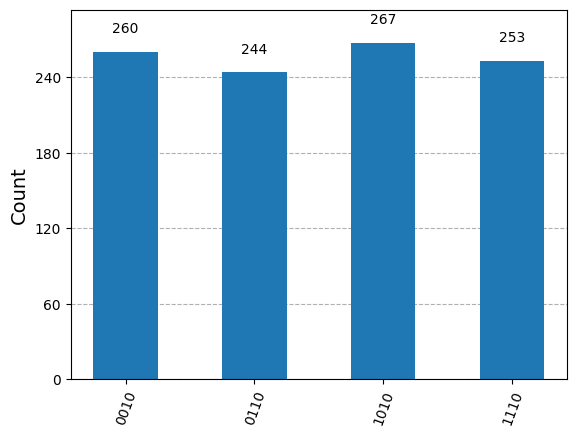

In [66]:
plot_histogram(res.get_counts())

you can see least significant bit q_0 is always 0 and rest are set according

now lets flip the results

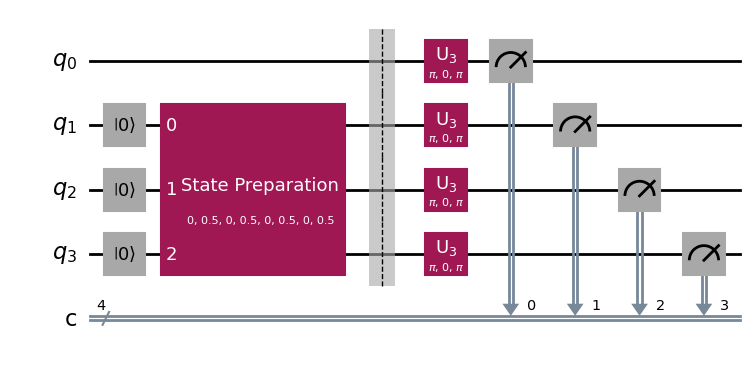

In [67]:
qc_init_3 = QuantumCircuit(4,4)
# initializing 3 qubits with an 8-element array, representing the amplitudes for all possible 3-qubit states (|000⟩, |001⟩, |010⟩, etc.).
qc_init_3.initialize([0, 1, 0, 1, 0, 1, 0, 1]/np.sqrt(4), [1,2,3])
qc_init_3.barrier(range(4))
for idx in range(4):
    qc_init_3.x(idx)
qc_init_3.measure(qubit=range(4), cbit=range(4))
qc_init_3.decompose().draw('mpl')

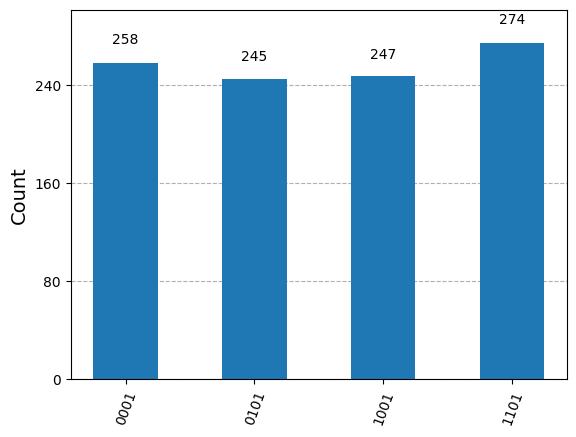

In [68]:
res = simulator.run(qc_init_3, memory=True).result()
res.get_counts()
plot_histogram(res.get_counts())